In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# !apt-get -qq install python-cartopy python3-cartopy
# ^ installs cartopy 0.14
# so instead install dependencies and download using pip
!apt-get install -qq libgdal-dev libproj-dev
!pip install cartopy==0.18
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install cmocean
!pip install xarray --upgrade
# !pip install matplotlib 
# !pip install eccodes
# !pip install cfgrib
# !sudo apt-get install libeccodes0

     |████████████████████████████████| 14.4MB 12.5MB/s 
     |████████████████████████████████| 225kB 62.9MB/s 
  Created wheel for cartopy: filename=Cartopy-0.18.0-cp37-cp37m-linux_x86_64.whl size=15127712 sha256=6b81c4b1b6ad3785a21fd05bf9dab5b855bb7afb897d6b065217dc1b21729b54
  Stored in directory: /root/.cache/pip/wheels/8d/f8/da/2c05136f2162370d2baec85bfbbf91d7729ab9e248da878acd
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=6b5d71aef44ebe7ac181f0fe60f0ff6d8faa2470cb3bb40447875d55aa4f4fb6
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built cartopy pyshp
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
     |████████████████████████████████| 389kB 15.7MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Run

In [3]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as ss
from cmocean import cm as cmo
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

In [4]:
# June, July & August data from 1979-2020
ds = xr.open_dataset("/content/drive/MyDrive/climate-data/ERA5_1979-2020.nc", chunks={'time':100}).sel(expver=1)
swvl = xr.open_dataset("/content/drive/MyDrive/climate-data/ERA5_1979-2020_SWVL.nc", chunks={'time':100}).sel(expver=1)

ds
# what is expver? 1 and 5

# t2m: 2 metre temp
# slhf: surface latent heat flux
# sshf: surface sensible heat flux
# swvl1: volumetric soil water layer 1 ie top 7 cm in soil

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 504)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-12 20:26:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
swvl

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 505)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Data variables:
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-02 21:48:46 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [6]:
# preprocessing data

# slhf and sshf: multiply by -1/86400 to correct direction of energy flow and
# convert from J/m^2 to W/m^2 (era5 stores data on daily basis)
ds['slhf'] = ds.slhf*(-1/86400)
ds.slhf.attrs['units'] = "W m**-2"
ds.slhf.attrs['long_name'] = "Surface latent heat flux"

ds['sshf'] = ds.sshf*(-1/86400)
ds.sshf.attrs['units'] = "W m**-2"
ds.sshf.attrs['long_name'] = "Surface sensible heat flux"

# swvl1: multiply by 70 to convert from m^3/m^3 to kg in top 7 cm
ds['swvl1'] = ds.swvl1*(70)
ds.swvl1.attrs['units'] = "kg m**-2 in top 7 cm"
ds.swvl1.attrs['long_name'] = "Volumetric soil water layer 1"

rootzone_swvl = (swvl.swvl1)*70 + (swvl.swvl2)*210 + (swvl.swvl3)*720
rootzone_swvl.attrs['units'] = "kg m**-3"
rootzone_swvl.attrs['long_name'] = "Root zone soil moisture"

In [7]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_seasonality(x):
#     return((x-x.groupby('time.month').mean()).drop('month'))
    return x.groupby('time.month').map(remove_time_mean)

def jja(month):
    return (month >= 6) & (month <= 8)

def djf(month):
    return (month == 12) | (month <= 2)

In [31]:
summer_swvl = xr.concat([rootzone_swvl.sel(time=jja(rootzone_swvl['time.month'])).where(lambda x: x.latitude>0, drop=True), 
                         rootzone_swvl.sel(time=djf(rootzone_swvl['time.month'])).where(lambda x: x.latitude<=0, drop=True)], dim='latitude')
summer_swvl = summer_swvl.where(lambda x: x>0.001)
weights = np.cos(np.deg2rad(summer_swvl.latitude))
weighted_summer_swvl = summer_swvl.weighted(weights)
summer_mean = weighted_summer_swvl.mean(skipna=True)
summer_mean.values

array(138.02909303)

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


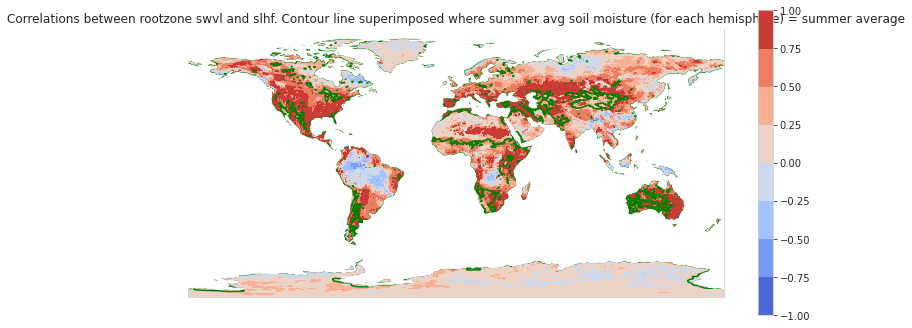

In [32]:
jja_corr = xr.corr(remove_seasonality(ds.slhf.sel(time=jja(ds.slhf['time.month']))), 
        remove_seasonality(rootzone_swvl.sel(time=jja(rootzone_swvl['time.month']))), dim='time')

djf_corr = xr.corr(remove_seasonality(ds.slhf.sel(time=djf(ds.slhf['time.month']))), 
        remove_seasonality(rootzone_swvl.sel(time=djf(rootzone_swvl['time.month']))), dim='time')

c = xr.concat([jja_corr.where(jja_corr['latitude']>=0, drop=True), 
               djf_corr.where(djf_corr['latitude']<0, drop=True)],
              dim='latitude')

mean_jja_swvl = rootzone_swvl.sel(time=jja(rootzone_swvl['time.month'])).mean(dim='time').where(lambda x: x.latitude>0, drop=True)
mean_djf_swvl = rootzone_swvl.sel(time=djf(rootzone_swvl['time.month'])).mean(dim='time').where(lambda x: x.latitude<0, drop=True)

lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

plt.contour(longs, lats.where(lambda x: x>0, drop=True), mean_jja_swvl, levels=[138.02909303], colors='green')
plt.contour(longs, lats.where(lambda x: x<0, drop=True), mean_djf_swvl, levels=[138.02909303], colors='green')

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

plt.title("Correlations between rootzone swvl and slhf. Contour line superimposed where summer avg soil moisture (for each hemisphere) = summer average")
plt.savefig("/content/drive/MyDrive/climate-data/figs/rootzone-swvl_slhf__era5.pdf")

In [8]:
jja_corr = xr.corr(remove_seasonality(ds.slhf.sel(time=jja(ds.t2m['time.month']))), 
        remove_seasonality(ds.swvl1.sel(time=jja(ds.t2m['time.month']))), dim='time')

djf_corr = xr.corr(remove_seasonality(ds.slhf.sel(time=djf(ds.t2m['time.month']))), 
        remove_seasonality(ds.swvl1.sel(time=djf(ds.t2m['time.month']))), dim='time')

c = xr.concat([jja_corr.where(jja_corr['latitude']>=0, drop=True), 
               djf_corr.where(djf_corr['latitude']<0, drop=True)],
              dim='latitude')

c

<xarray.DataArray (latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(721, 1440), dtype=float64, chunksize=(361, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


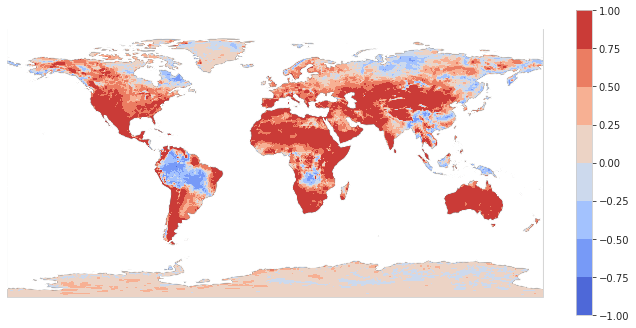

In [9]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

In [10]:
# calculate summer swvl1 average in northern hemisphere

jja_swvl1 = ds.swvl1.sel(time=jja(ds.swvl1['time.month'])).where(lambda x: (x>0.001) & (x.latitude>0), drop=True)
weights = np.cos(np.deg2rad(jja_swvl1.latitude))
weighted_jja_swvl1 = jja_swvl1.weighted(weights)
north_mean = weighted_jja_swvl1.mean(skipna=True)
north_mean.values

array(17.536625, dtype=float32)

In [11]:
# calculate summer swvl1 average in southern hemisphere

djf_swvl1 = ds.swvl1.sel(time=djf(ds.swvl1['time.month'])).where(lambda x: (x>0.001) & (x.latitude<0), drop=True)
weights = np.cos(np.deg2rad(djf_swvl1.latitude))
weighted_djf_swvl1 = djf_swvl1.weighted(weights)
south_mean = weighted_djf_swvl1.mean(skipna=True)
south_mean.values

array(18.617659, dtype=float32)

In [12]:
summer_swvl1 = xr.concat([ds.swvl1.sel(time=jja(ds.swvl1['time.month'])).where(lambda x: x.latitude>0, drop=True), 
                          ds.swvl1.sel(time=djf(ds.swvl1['time.month'])).where(lambda x: x.latitude<=0, drop=True)], dim='latitude')
summer_swvl1 = summer_swvl1.where(lambda x: x>0.001)
weights = np.cos(np.deg2rad(summer_swvl1.latitude))
weighted_summer_swvl1 = summer_swvl1.weighted(weights)
summer_mean = weighted_summer_swvl1.mean(skipna=True)
summer_mean.values

array(17.90745995)

In [26]:
mean_jja_swvl1 = ds.swvl1.sel(time=jja(ds.swvl1['time.month'])).mean(dim='time')
mean_djf_swvl1 = ds.swvl1.sel(time=djf(ds.swvl1['time.month'])).mean(dim='time')

In [29]:
top_swvl = ds.swvl1.where(lambda x: x>0.001, drop=True)
weights = np.cos(np.deg2rad(top_swvl.latitude))
weighted_swvl1 = top_swvl.weighted(weights)
annual_mean = weighted_swvl1.mean()
annual_mean.values

array(17.435389, dtype=float32)

Text(0.5, 1.0, 'ERA5: (JJA SWVL1-DJF SWVL1)/Annual Mean')

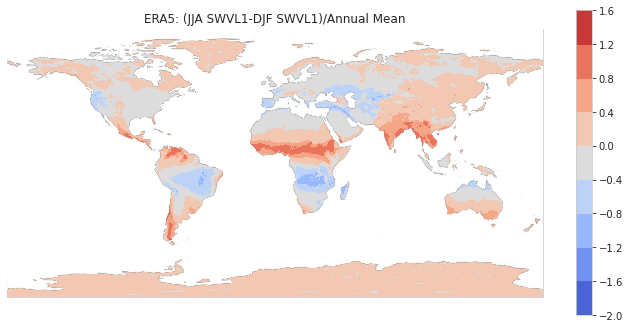

In [30]:
lats = ds.latitude
longs = ds.longitude
Diff_JJA_DJF = (mean_jja_swvl1-mean_djf_swvl1)/17.435389

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, Diff_JJA_DJF, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
plt.title("ERA5: (JJA SWVL1-DJF SWVL1)/Annual Mean")

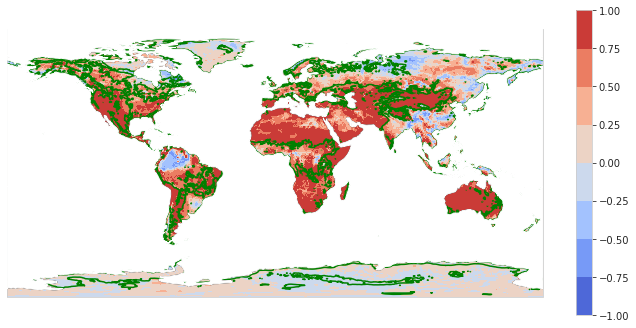

In [14]:
# JJA plot (i.e. correct for Northern hemisphere)

lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, jja_corr, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

plt.contour(longs, lats, mean_jja_swvl1, levels=[17.536644], colors='green')

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


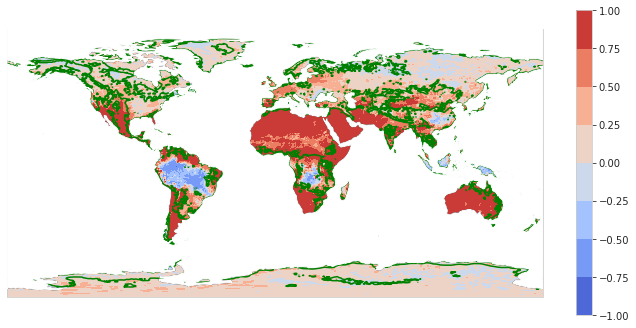

In [15]:
# DJF plot (i.e. correct for Southern hemisphere)

lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, djf_corr, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

plt.contour(longs, lats, mean_djf_swvl1, levels=[18.617683], colors='green')

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

In [16]:
mean_jja_swvl1 = mean_jja_swvl1.where(lambda x: x.latitude>0, drop=True)
mean_djf_swvl1 = mean_djf_swvl1.where(lambda x: x.latitude<0, drop=True)

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Correlations between swvl1 and slhf. Contour line superimposed where summer avg soil moisture (for each hemisphere) = hemispheric average')

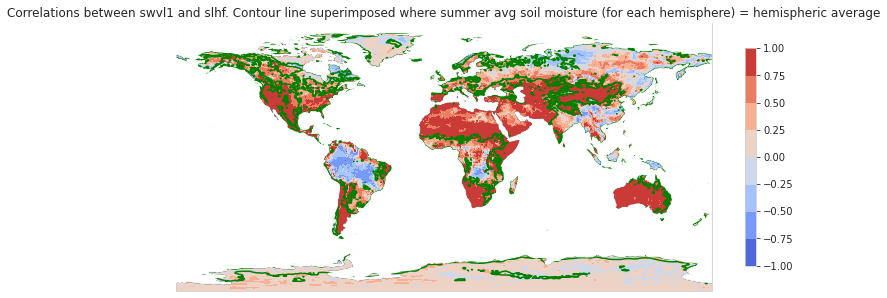

In [17]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c, cmap='coolwarm')
plt.colorbar(shrink=0.5)
ax.coastlines()

plt.contour(longs, lats.where(lambda x: x>0, drop=True), mean_jja_swvl1, levels=[17.536644], colors='green')
plt.contour(longs, lats.where(lambda x: x<0, drop=True), mean_djf_swvl1, levels=[18.617683], colors='green')

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
plt.title("Correlations between swvl1 and slhf. Contour line superimposed where summer avg soil moisture (for each hemisphere) = hemispheric average")

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


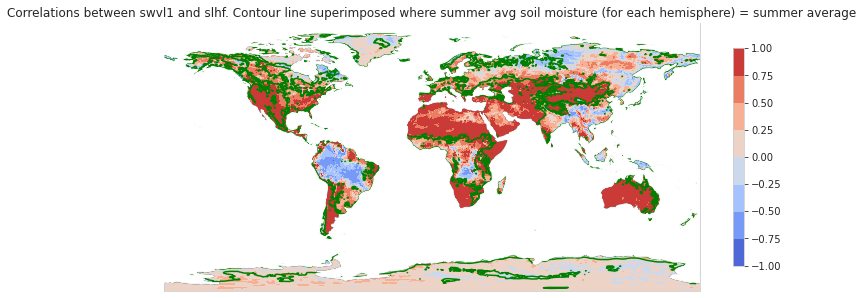

In [18]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c, cmap='coolwarm')
plt.colorbar(shrink=0.5)
ax.coastlines()

plt.contour(longs, lats.where(lambda x: x>0, drop=True), mean_jja_swvl1, levels=[17.90745995], colors='green')
plt.contour(longs, lats.where(lambda x: x<0, drop=True), mean_djf_swvl1, levels=[17.90745995], colors='green')

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
plt.title("Correlations between swvl1 and slhf. Contour line superimposed where summer avg soil moisture (for each hemisphere) = summer average")
plt.savefig("/content/drive/MyDrive/climate-data/figs/vargas_fig-4__era5.pdf")

In [19]:
jja_corr_2 = xr.corr(remove_seasonality(ds.sshf.sel(time=jja(ds.sshf['time.month']))), 
        remove_seasonality(ds.t2m.sel(time=jja(ds.t2m['time.month']))), dim='time')

djf_corr_2 = xr.corr(remove_seasonality(ds.sshf.sel(time=djf(ds.sshf['time.month']))), 
        remove_seasonality(ds.t2m.sel(time=djf(ds.t2m['time.month']))), dim='time')

c_2 = xr.concat([jja_corr_2.where(jja_corr_2['latitude']>=0, drop=True), 
               djf_corr_2.where(djf_corr_2['latitude']<0, drop=True)],
              dim='latitude')

c_2

<xarray.DataArray (latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(721, 1440), dtype=float64, chunksize=(361, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


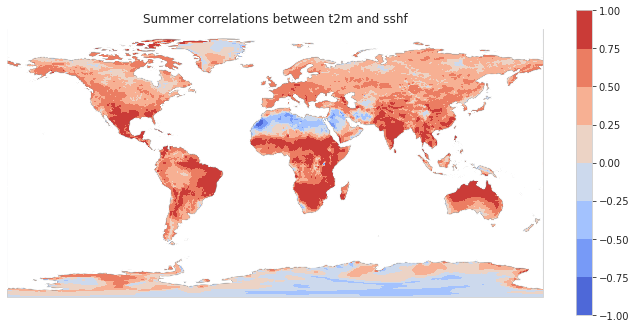

In [20]:
lats = ds.latitude
longs = ds.longitude

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(longs, lats, c_2, cmap='coolwarm')
plt.colorbar(shrink=0.7)
ax.coastlines()

# look into correlations over ocean
ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
plt.title("Summer correlations between t2m and sshf")
plt.savefig("/content/drive/MyDrive/climate-data/figs/t2m_sshf-corr_era5.pdf")

In [21]:
def grid_climatology(data,mn=None,mx=None,lvn=10,limits=False,cmap=cmo.thermal,hide_ocean=False,save=False,savetype='pdf'):
    lat = data.latitude
    lon = data.longitude

    fig,axes = plt.subplots(nrows=4, ncols=3,figsize=(14,10),dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axes.flatten()
    for i in np.arange(0,12):
        avg = data.sel({'time': data['time.month']==i+1}).mean('time') 
        im = axes.flat[i].contourf(lon, lat, avg, levels=np.linspace(mn,mx,lvn+1),cmap=cmap,extend='both')
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)
        axs[i].coastlines()
        axs[i].set_title('Month: '+ str(i+1),fontsize=15)
        if(hide_ocean):
            axs[i].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
    
    fig.colorbar(im, ax=axes.ravel().tolist(),cax=fig.add_axes([0.92,0.1,.03,.8]))
    plt.subplots_adjust()
    plt.suptitle('ERA 5: {}, Units:{}'.format(data.attrs['long_name'], data.attrs['units']), fontsize=18)
    if(save):
        plt.savefig('figs/gr_' + data.attrs['long_name'] +
                    '_monthly.' + str(savetype))
    plt.show()

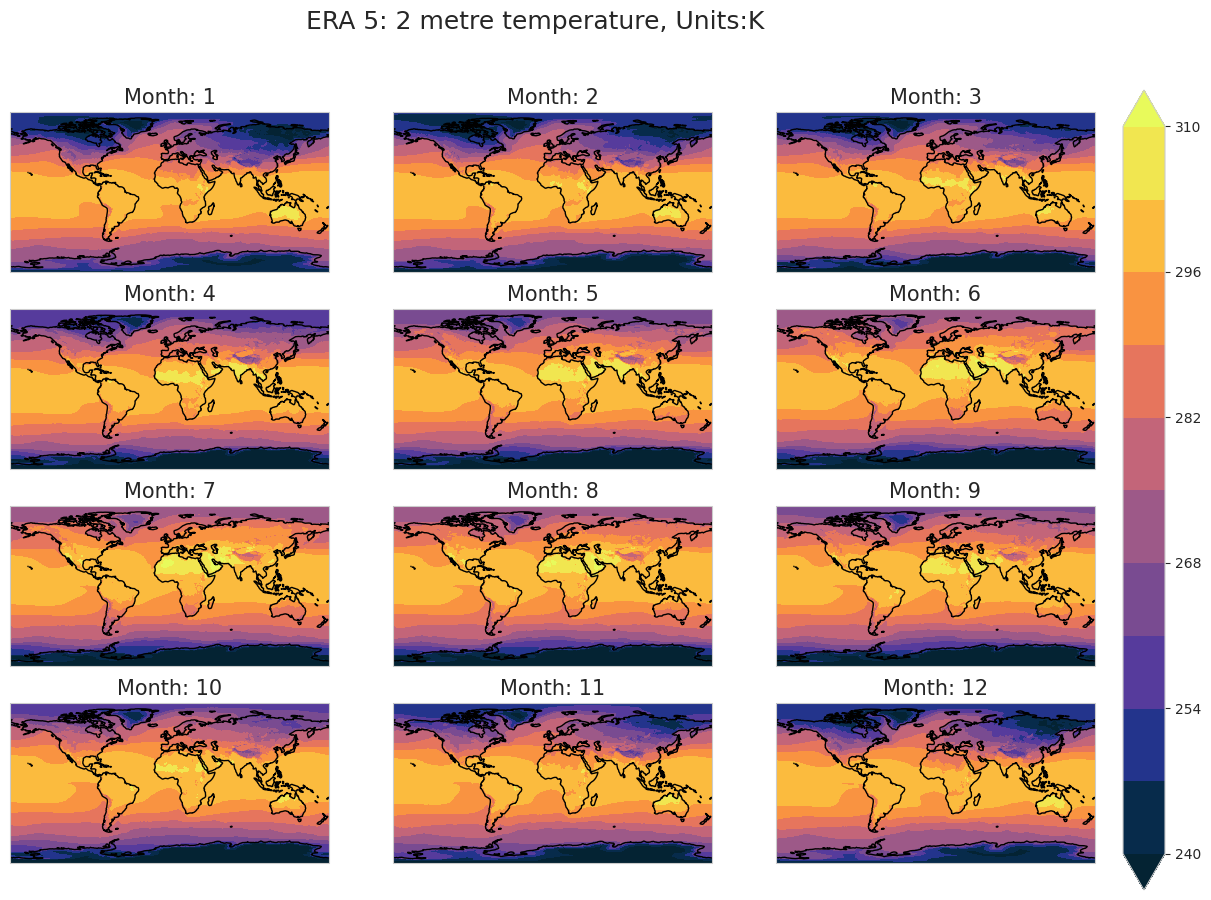

In [22]:
grid_climatology(ds.t2m, 240, 310, limits=True)

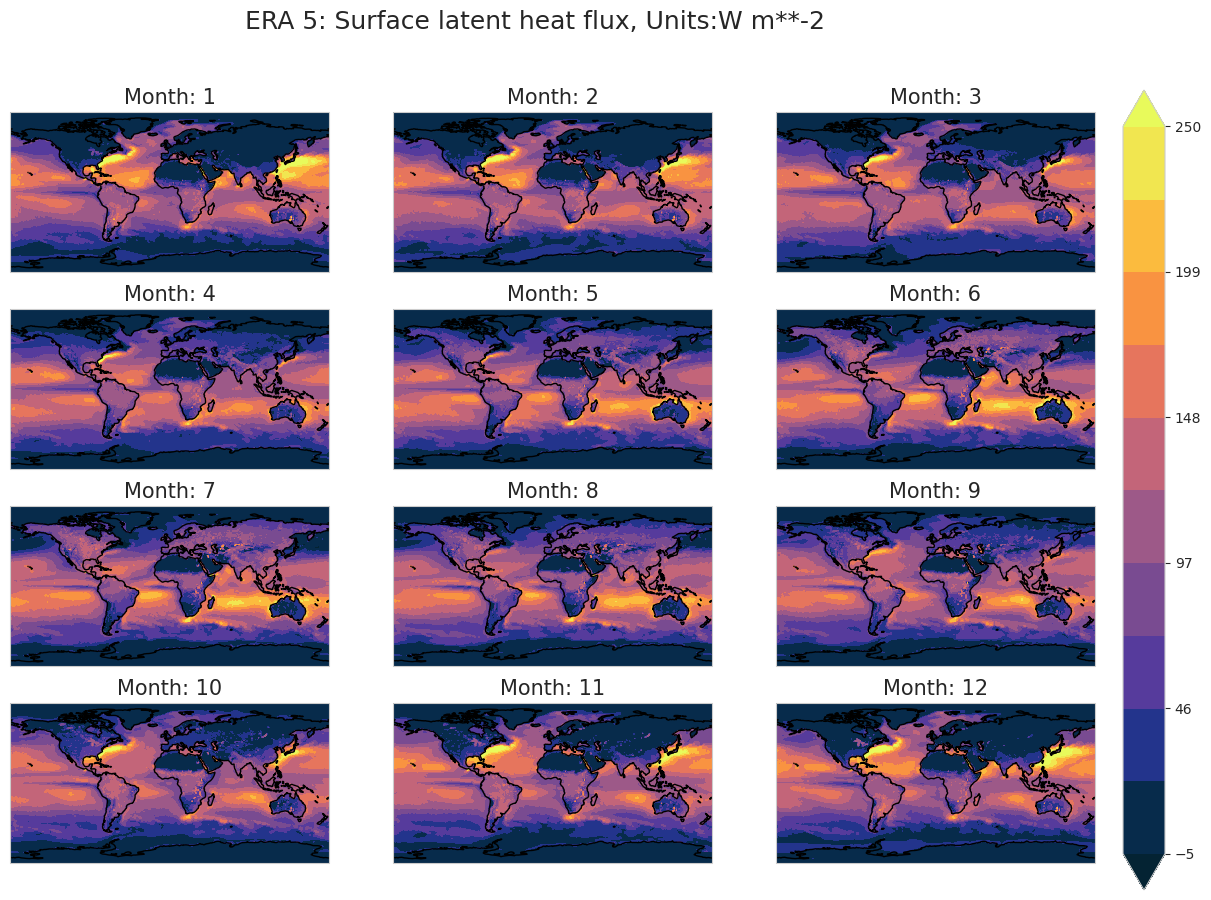

In [23]:
grid_climatology(ds.slhf, -5, 250, limits=True)

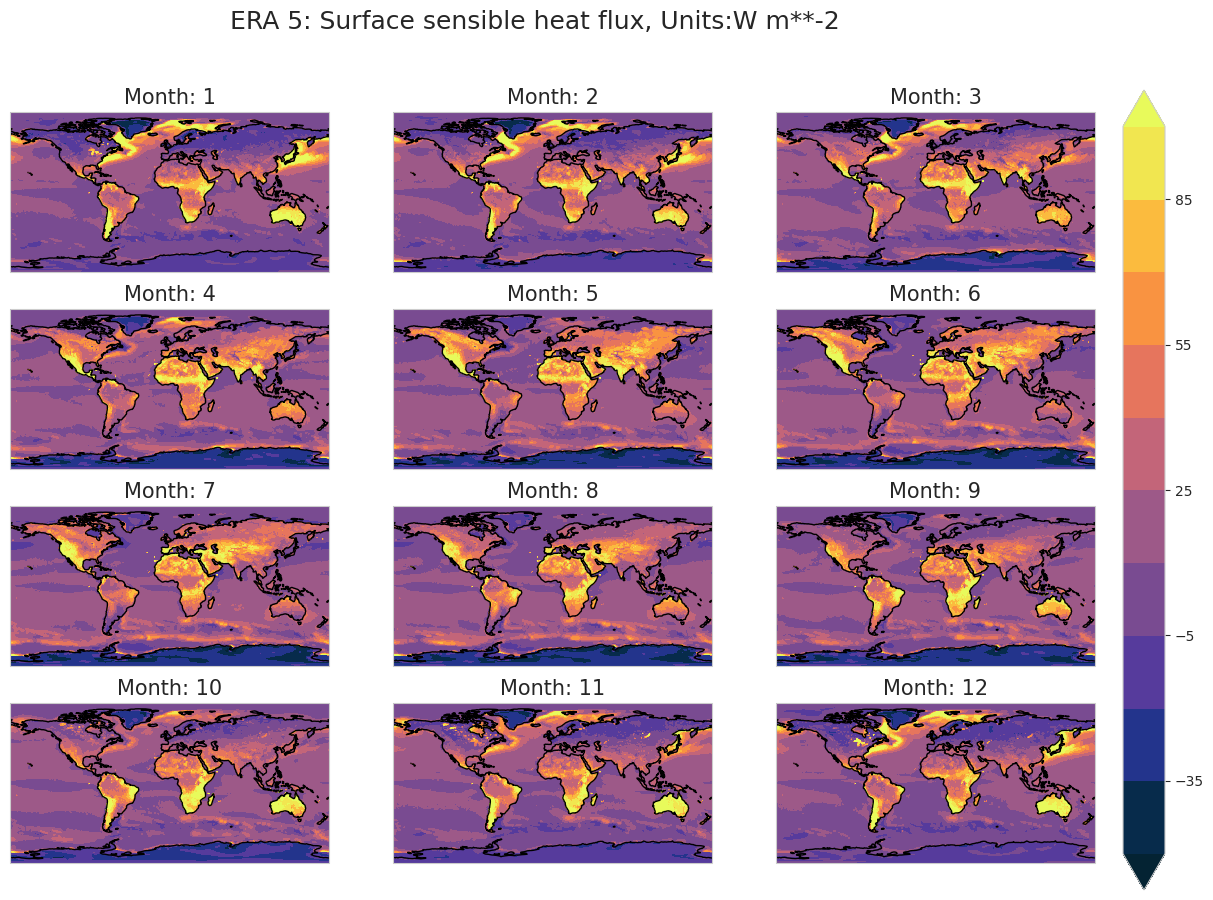

In [24]:
grid_climatology(ds.sshf, -50, 100, limits=True)

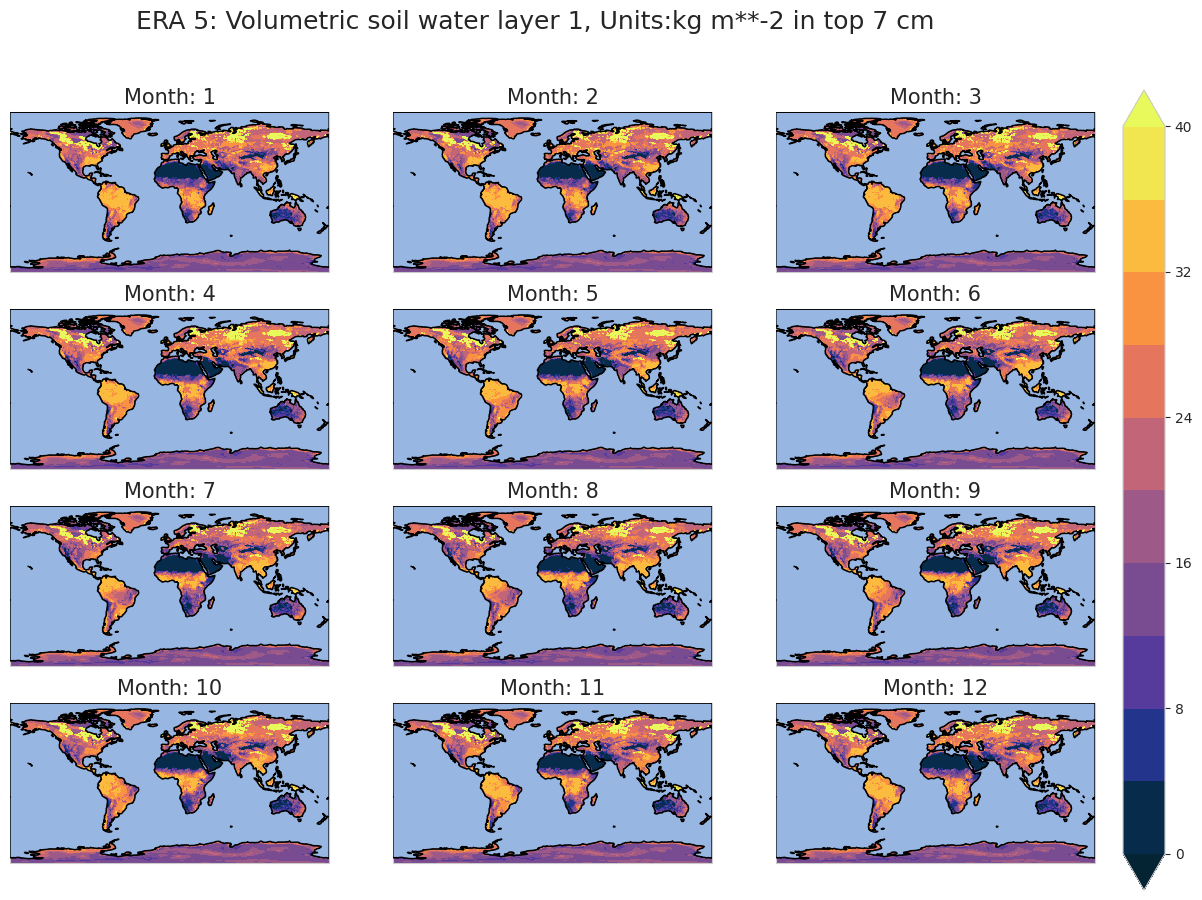

In [25]:
grid_climatology(ds.swvl1, 0, 40, limits=True, hide_ocean=True)